In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

## Giới thiệu Dataset:
##### Dataset chứa tất cả các giao dịch xảy ra từ ngày 12/01/2010 đến ngày 12/09/2011 trong lĩnh vực Ecommerce.
Thông tin các cột trong file dữ liệu:
* **InvoiceNo**: Id Hoá đơn
* **StockCode**: Id của các mặt hàng đã mua
* **Description**: Môt tả của mặt hàng
* **Quantity**: Số lượng của mặt hàng đã mua.
* **InvoiceDate**: Ngày mua
* **UnitPrice**: Giá của mặt hàng
* **CustomerID**: Id khách hàng đã mua hàng
* **Country**: Tên quốc gia của khách hàng



## Customer Segmentation:

Customer segmentation là quá trình phân chia khách hàng của công ty, doanh nghiệp thành các nhóm hoặc phân khúc khác nhau dựa trên các thuộc tính khác nhau của khách hàng. Quá trình phân khúc khách hàng dựa trên tìm kiếm sự khác biệt giữa hành vi hoặc đặc điểm của khách hàng.

Các mục tiêu và lợi ích chính của việc phân khúc khách hàng:

* **Tăng doanh thu:** Đây là mục tiêu rõ ràng nhất của bất kỳ nhiệm vụ phân khúc khách hàng nào
* **Hiểu khách hàng:** Một trong những mô hình kinh doanh được ngày càng phổ biến là “know your customer - KYC”, việc phân khúc được khách hàng sẽ giúp ích rất nhiều cho mô hình này.
* **Marketing:** Lợi ích dễ thấy nhất của việc phân khúc khách hàng là khả năng tập trung các tiếp thị một cách hiệu quả. Nếu một công ty biết các phân khúc khác nhau trong cơ sở khách hàng của mình, thì công ty có thể đưa ra các chiến dịch tiếp thị tốt hơn được thiết kế riêng cho phân khúc đó. Một mô hình phân khúc tốt cho phép hiểu rõ hơn về các yêu cầu của khách hàng và do đó làm tăng cơ hội thành công của bất kỳ chiến dịch tiếp thị nào do tổ chức phát triển.

* **Đặt vị trí thích hợp cho Sản phẩm** Một chiến lược phân khúc khách hàng tốt cũng có thể giúp công ty phát triển hoặc cung cấp các sản phẩm mới, hoặc một nhóm sản phẩm với nhau như một hình thức cung cấp kết hợp.
* **Tìm các phân khúc khách hàng tiềm ẩn:** Tìm ra phân khúc khách hàng có thể còn thiếu để xác định phân khúc khách hàng chưa được khai thác bằng cách tập trung vào các chiến dịch tiếp thị hoặc phát triển kinh doanh mới.

## Mô hình RFM đại diện cho giá trị khách hàng:

Vì tập dữ liệu của chúng ta được giới hạn trong lịch sử bán hàng và không bao gồm thông tin ẩn danh về khách hàng, nên chúng ta sẽ sử dụng mô hình dựa trên RFM. Mô hình RFM sẽ lấy các giao dịch của một khách hàng và tính toán ba thuộc tính thông tin quan trọng về mỗi khách hàng:
* **Recency**: Giá trị của mức độ gần đây một khách hàng đã mua hàng
* **Frequency**: Mức độ thường xuyên của các giao dịch của khách hàng
* **Monetary value**: Số tiền (hoặc bảng Anh trong bài ASM) của tất cả các giao dịch mà khách hàng đã thực hiện


# 1. Import thư viện và tải dữ liệu

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import datetime
import math
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
import plotly as py
from sklearn.metrics import silhouette_samples, silhouette_score
import plotly.graph_objs as go
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

Hàm dưới đây sẽ phục vụ cho việc vẽ các biểu đồ phân phối

In [3]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [4]:
df = pd.read_csv('Online Retail.csv')

In [5]:
data = df.copy()

# 2. Exploratory Data Analysis

In [6]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Nhìn vào bảng mô tả phía trên, chúng ta có thể thấy cột **Quantity** và **UnitPrice** có xuất hiện giá trị âm, điều này là không hợp lý trừ khi sẽ có những giao dịch dạng trả hàng thì sẽ khiến hai cột này có giá trị âm. Mục tiêu của chúng ta là phân khúc hàng nên chúng ta sẽ cần loại bỏ những giá trị này (chỉ cần quan tâm những khách hàng mua hàng, những khách hàng trả hàng chúng ta không cần quan tâm đến).

* Kiểm tra xem có giao dịch nào có Quantity và  UnitPrice đều nhỏ hơn 0 hay không:
* Kiểm tra xem có bao nhiêu giao dịch có Quantity < 0 và Unitpirce = 0 hoặc ngược lại:
* ID các khách hàng ở trong các giao dịch ở ý trên là gì: 
* Tỷ lệ Quantity nhỏ hơn 0 trên tất cả các giao dịch là bao nhiêu:
* Tất cả các giao dịch với Quantity âm đều có Hoá đơn bắt đầu bằng ký tự gì:


In [7]:
# Kiểm tra xem có giao dịch nào có Quantity và UnitPrice đều nhỏ hơn 0 hay không:

data.loc[(data['Quantity'] < 0) & (data['UnitPrice'] < 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [8]:
# Kiểm tra xem có bao nhiêu giao dịch có Quantity < 0 và Unitpirce = 0 hoặc ngược lại:

# Số lượng giao dịch có Quantity < 0 và UnitPrice = 0
q_neg_p_zero = len(data.loc[(data['Quantity'] < 0) & (data['UnitPrice'] == 0)])
# Số lượng giao dịch có Quantity = 0 và UnitPrice < 0
q_zero_p_neg = len(data.loc[(data['Quantity'] == 0) & (data['UnitPrice'] < 0)])

print(f'Số lượng giao dịch có Quantity < 0 và UnitPrice = 0: {q_neg_p_zero} ')
print(f'Số lượng giao dịch có Quantity = 0 và UnitPrice < 0: {q_zero_p_neg} ')


Số lượng giao dịch có Quantity < 0 và UnitPrice = 0: 1336 
Số lượng giao dịch có Quantity = 0 và UnitPrice < 0: 0 


In [9]:
# ID các khách hàng ở trong các giao dịch ở ý trên là gì:

# ID các khách hàng trong giao dịch có Quantity < 0 và UnitPrice = 0
data.loc[(data['Quantity'] < 0) & (data['UnitPrice'] == 0), 'CustomerID'].unique()


array([nan])

In [10]:
# Tỷ lệ Quantity nhỏ hơn 0 trên tất cả các giao dịch là bao nhiêu:

neg_qty_ratio = len(data.loc[data['Quantity'] < 0]) / len(data) * 100
print(f'Tỷ lệ Quantity nhỏ hơn 0 trên tất cả các giao dịch là: {neg_qty_ratio:.2f}%')

Tỷ lệ Quantity nhỏ hơn 0 trên tất cả các giao dịch là: 1.96%


In [11]:
# Tất cả các giao dịch với Quantity âm đều có Hoá đơn bắt đầu bằng ký tự gì:

# Lấy mã hoá đơn của các giao dịch đó
invoice_codes = data['InvoiceNo'].loc[(data['Quantity'] < 0)].unique()
# Lấy ký tự đầu tiên của mã hoá đơn
first_char = [code[0] for code in invoice_codes]
first_char_set = set(first_char)


print(f'Tất cả các giao dịch với Quantity âm đều có Hoá đơn bắt đầu bằng ký tự: {first_char_set}')

Tất cả các giao dịch với Quantity âm đều có Hoá đơn bắt đầu bằng ký tự: {'5', 'C'}


## 3. Data preparation

Khi chúng ta đã tạo tập dữ liệu giá trị khách hàng của mình, chúng ta sẽ thực hiện một số bước tiền xử lý dữ liệu. Trong trường hợp này, chúng ta sẽ sử dụng thuật toán phân cụm K-mean. Một trong những yêu cầu để thuật toán hoạt động đúng cách là chuẩn hoá giá trị các biến tính năng. Căn giữa trung bình của một giá trị là việc thay thế giá trị thực của biến bằng một giá trị chuẩn hóa, để biến có giá trị trung bình là 0 và phương sai là 1. Điều này đảm bảo rằng tất cả các biến đều nằm trong cùng một phạm vi.

Trong các dữ liệu có biến Price hay giá tiền thì thường những biến này có giá trị rất lớn. Để giải quyết vấn đề này, chúng ta sẽ biến đổi tất cả các biến trên thang log. Việc chuyển đổi này, cùng với việc chuẩn hóa, sẽ đảm bảo rằng đầu vào cho thuật toán là một tập hợp các giá trị có cùng khoảng giá trị.



In [12]:
# Xoá các hàng có CustomerID là null
cs_df = data.dropna(subset='CustomerID')

# Xoá các hàng có Quantity < 0
cs_df = cs_df[cs_df['Quantity'] > 0]

# Lấy các hàng có UnitPrice > 0
cs_df = cs_df[cs_df['UnitPrice'] > 0]

In [13]:
# Định dạng các cột InvoiceDate, CustomerID
cs_df.InvoiceDate = pd.to_datetime(cs_df.InvoiceDate)
cs_df.CustomerID = cs_df.CustomerID.astype('Int64')
# Thêm cột 'amount' để tính Monetery
cs_df['amount'] = cs_df.Quantity*cs_df.UnitPrice

#### **Tạo biến Recency và in ra thông tin mô tả của biến Recency vừa tạo**
Thực hiện tạo biến Recency, chúng ta cần quyết định ngày tham chiếu cho phân tích. Thông thường, chúng ta sẽ sử dụng ngày giao dịch cuối cùng cộng với một ngày. Sau đó, chúng ta sẽ xây dựng biến recency là số ngày trước ngày tham chiếu khi khách hàng mua hàng lần cuối.

Ví dụ: Ngày cuối cùng mà xuất hiện đơn mua hàng của khách hàng là ngày thứ 10 như vậy chúng sẽ lấy 10 + 1 = 11. Sau đó chúng ta sẽ lấy số 11 trừ đi ngày cuối cùng mà mỗi khách hàng mua hàng. Giả sử lần cuối cùng mà khách hàng A mua hàng là ngày 5, và lần cuối cùng mà khách hàng B mua hàng là ngày 7 ta sẽ có Recency cho khách hàng A sẽ là 11 - 5 = 6, và Recency cho khách hàng B là 11 - 7 = 4

In [14]:
# Tìm ngày cuối cùng trong dữ liệu cộng thêm 1 ngày vào 
last_date = cs_df['InvoiceDate'].max() 
reference_date = last_date + pd.DateOffset(days=1)

# Tạo một DataFrame mới chứa thông tin về ngày mua hàng cuối cùng của mỗi khách hàng
recency_df = cs_df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_df['recency'] = (reference_date - recency_df['InvoiceDate']).dt.days
recency_df = recency_df.drop(columns='InvoiceDate')

print(f'Reference Date: {reference_date}')
recency_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00


,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,92.536422,100.014169,1.0,18.00,51.0,142.00,374.0


C:\Users\DELL.DESKTOP-1BP7V8J\AppData\Local\Temp\ipykernel_19364\2679653009.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


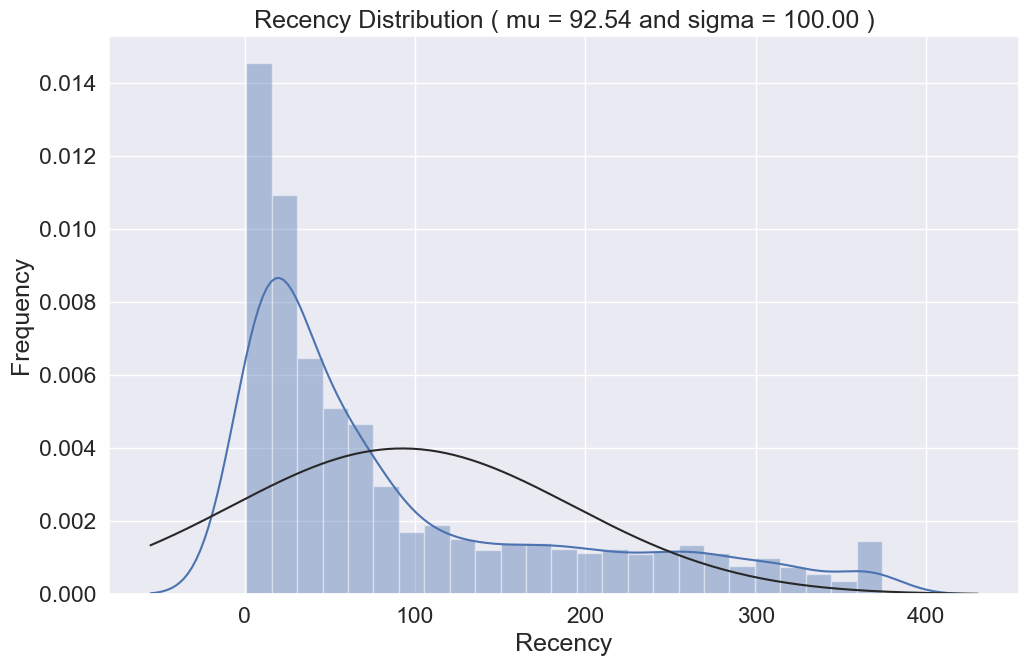

In [15]:
# Trực quan hoá biến Recency bằng cách sử dụng Hàm QQ_plot
QQ_plot(recency_df['recency'], 'Recency')

Từ biểu trên, chúng ta có thể thấy rằng phân phối của Recency bị lệch, có đỉnh ở bên trái và đuôi dài ở bên phải. Nó lệch khỏi phân phối chuẩn và có xu hướng dương.


#### **Tạo biến Frequency và in ra thông tin mô tả của biến Frequency vừa tạo**

Các bạn sẽ tính Frequency bằng cách đếm số đơn hàng mà mỗi khách hàng đã thực hiện mua (Lưu ý là các đơn hàng sẽ dạng distinct)

In [16]:
# Tạo DataFrame mới chứa thông tin về Frequency của mỗi khách hàng
frequency_df = cs_df.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].nunique()
frequency_df = frequency_df.rename(columns={'InvoiceNo': 'frequency'})
frequency_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
frequency,4338.0,4.272015,7.697998,1.0,1.00,2.0,5.00,209.0


C:\Users\DELL.DESKTOP-1BP7V8J\AppData\Local\Temp\ipykernel_19364\2679653009.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


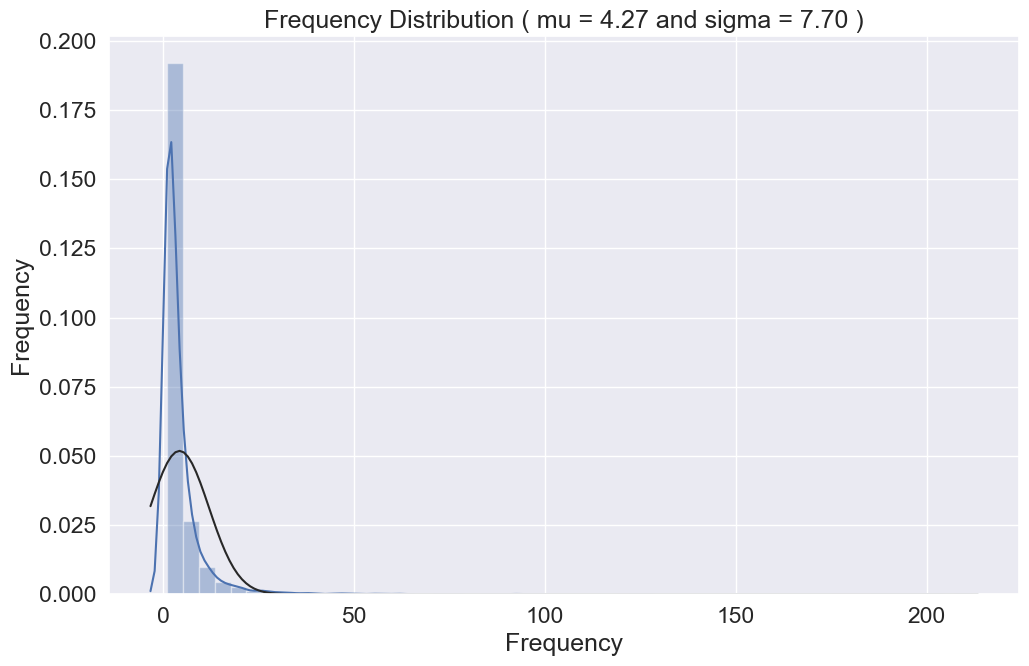

In [17]:
QQ_plot(frequency_df['frequency'],'Frequency')

Từ biểu trên, chúng ta có thể thấy rằng phân phối tần suất bán hàng bị lệch, có đỉnh ở bên trái và đuôi dài ở bên phải. Nó lệch khỏi phân phối chuẩn và có xu hướng dương.

#### **Tạo biến Monetary Value và trực quan hoá Monetary Value**



Để tính Monetary Value, chúng ta sẽ tính sum amount được group by theo CustomerID

In [18]:
# Tạo DataFrame mới chứa thông tin về amount của mỗi khách hàng
monetary_df = cs_df.groupby('CustomerID')['amount'].sum().reset_index()
monetary_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.00,13813.250,15299.500,16778.75,18287.00
amount,4338.0,2054.266460,8989.230441,3.75,307.415,674.485,1661.74,280206.02


C:\Users\DELL.DESKTOP-1BP7V8J\AppData\Local\Temp\ipykernel_19364\2679653009.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


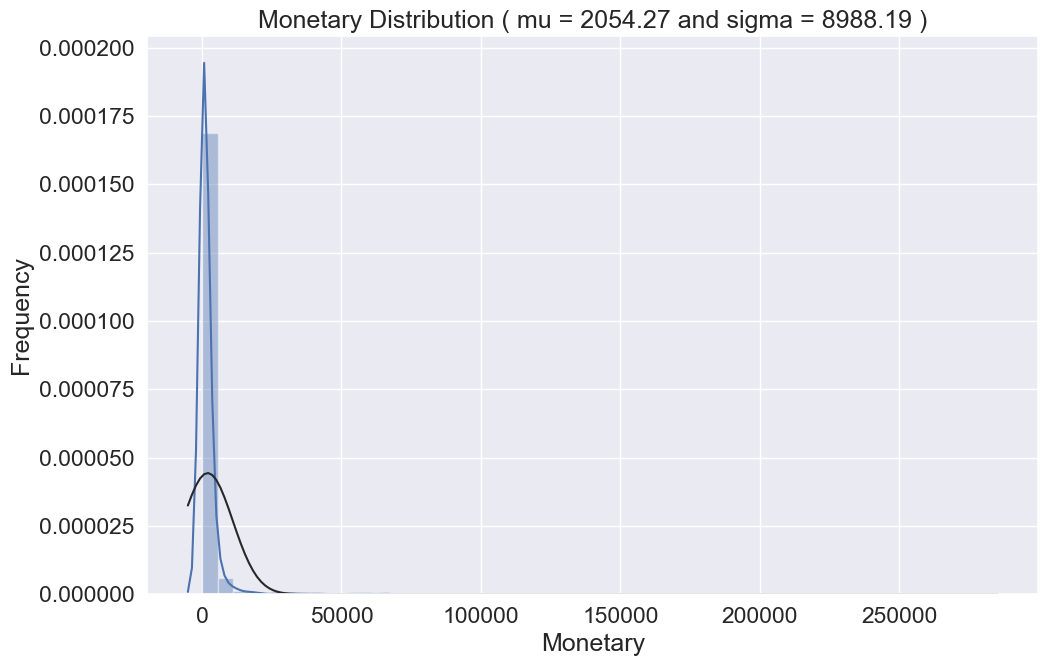

In [19]:
QQ_plot(monetary_df['amount'],'Monetary')

Từ biểu trên, chúng ta có thể thấy rằng phân phối  Monetary Value bị lệch, có đỉnh ở bên trái và đuôi dài ở bên phải. Nó lệch khỏi phân phối chuẩn và có xu hướng dương.

#### **Hiển thị ra thông tin mô tả của cả ba biến recency, frequency, amount theo CustomerID**

In [20]:
rfm_df = recency_df.merge(frequency_df, on='CustomerID')

rfm_df = rfm_df.merge(monetary_df, on='CustomerID')

rfm_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.00,13813.250,15299.500,16778.75,18287.00
recency,4338.0,92.536422,100.014169,1.00,18.000,51.000,142.00,374.00
frequency,4338.0,4.272015,7.697998,1.00,1.000,2.000,5.00,209.00
amount,4338.0,2054.266460,8989.230441,3.75,307.415,674.485,1661.74,280206.02



#### **Scale RBM trên thang đo log sau đó chuẩn hoá lại với StandardScaler**



In [21]:
# Scale biến Recency, Frequency, và Monetary trên thang đo log
customer_history_df = rfm_df
customer_history_df['recency_log'] = customer_history_df['recency'].apply(lambda x : math.log(x))
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(lambda x : math.log(x))
customer_history_df['amount_log'] = customer_history_df['amount'].apply(lambda x : math.log(x))

# Chuẩn hoá lại với StandardScaler
scaler = StandardScaler()
customer_history_df_scaled = scaler.fit_transform(customer_history_df[['recency_log','frequency_log','amount_log']])

In [22]:
customer_history_df.head()

,CustomerID,recency,frequency,amount,recency_log,frequency_log,amount_log
0,12346,326,1,77183.60,5.786897,0.000000,11.253942
1,12347,2,7,4310.00,0.693147,1.945910,8.368693
2,12348,75,4,1797.24,4.317488,1.386294,7.494007
3,12349,19,1,1757.55,2.944439,0.000000,7.471676
4,12350,310,1,334.40,5.736572,0.000000,5.812338


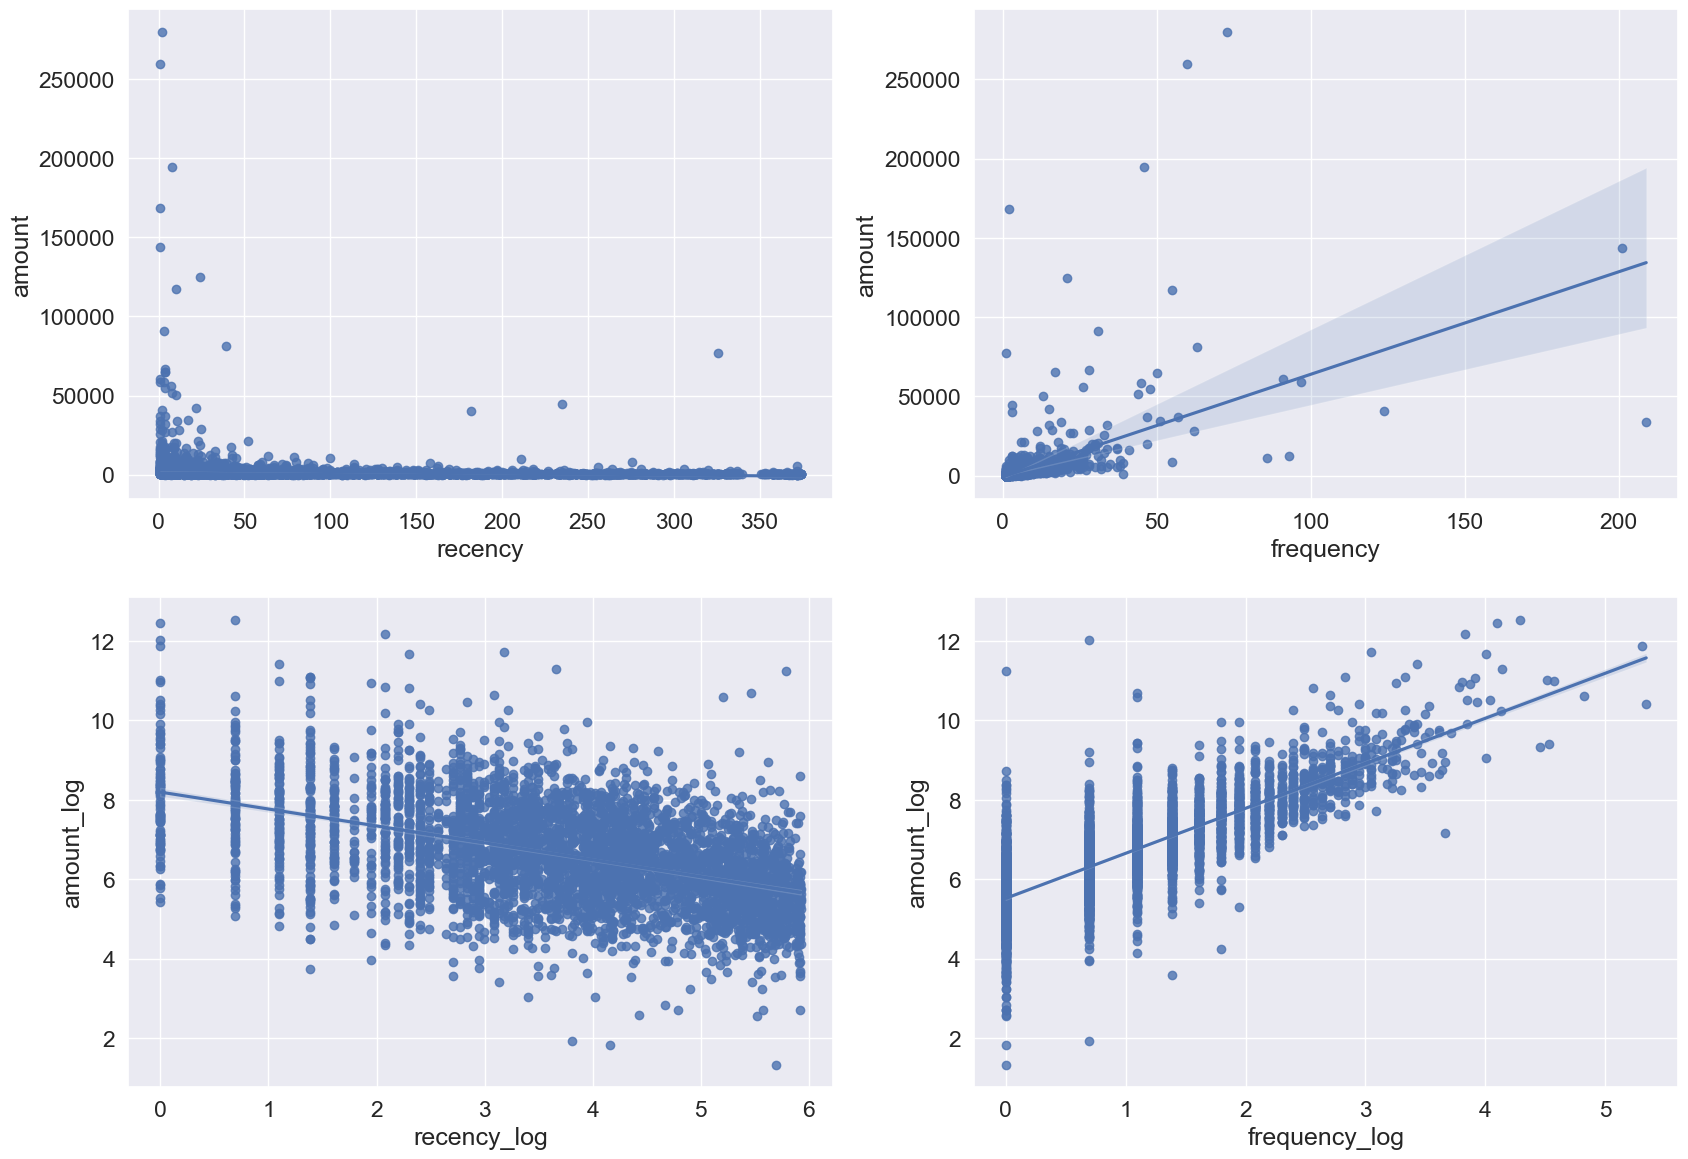

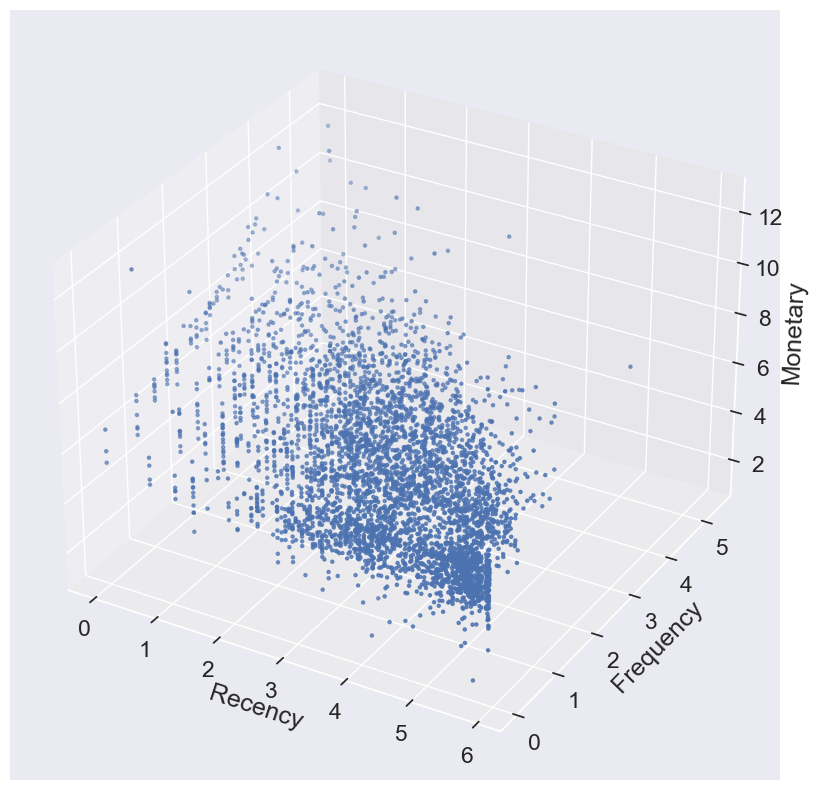

In [23]:
# Vẽ biểu đồ để quan sát tổng quát các biến recency, frequency, amount
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=customer_history_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=customer_history_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

### Nhận xét:

Chúng ta có thể thấy từ các biểu đồ ở trên, những người mua hàng với tần suất cao hơn (frequency) và  truy cập gần đây hơn (recency) có xu hướng chi tiêu nhiều hơn (Monetary value) dựa trên xu hướng ngày càng tăng của số tiền với xu hướng tăng và giảm tương ứng cho Tần suất và Lần truy cập gần đây.

Tiếp theo dựa vào biểu đồ 3 chiều, ta thấy  những khách hàng đã truy cập gần đây (recency) có nhiều khả năng quay lại hơn so với những khách hàng đã truy cập cách đây lâu. Do đó một lần nữa, tần suất cao hơn (frequency) sẽ được liên kết với những lần truy cập gần đây nhất.

# 4. Modeling - Kmean

#### **Phương pháp Elbow:**

Sử dụng phương pháp khuỷu tay (Elbow) để tìm số lượng cụm tối ưu. Ý tưởng đằng sau phương pháp khuỷu tay là xác định giá trị của k tại đó độ gấp khúc bắt đầu tăng nhanh nhất. Nếu k tăng, độ biến dạng của các cụm sẽ giảm, bởi vì các mẫu sẽ gần với trọng tâm cụm.

Phương pháp này xem xét phần trăm phương sai được giải thích như một hàm của số lượng cụm. Chính xác hơn, nếu ta vẽ biểu đồ phần trăm phương sai được giải thích bởi các cụm so với số lượng các cụm, các cụm đầu tiên sẽ bổ sung nhiều thông tin (giải thích nhiều phương sai), nhưng tại một số điểm, mức tăng cận biên sẽ giảm xuống (Số lượng cụm tăng, phương sai giảm), tạo ra một góc trong đồ thị, đây sẽ là điểm chọn số lượng cho cụm, do đó có "tiêu chí khuỷu tay". Phần trăm phương sai được giải thích là tỷ lệ giữa phương sai giữa nhóm với tổng phương sai, còn được gọi là F-test. Một biến thể nhỏ của phương pháp này vẽ biểu đồ độ cong của phương sai trong cụm

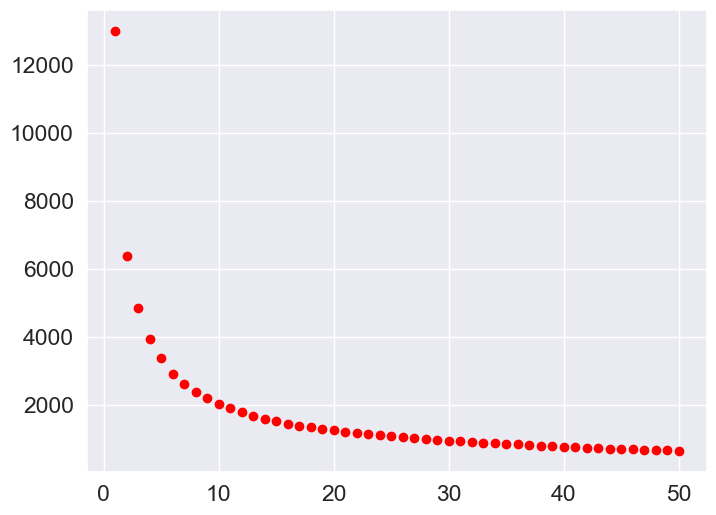

The best K sugest:  7


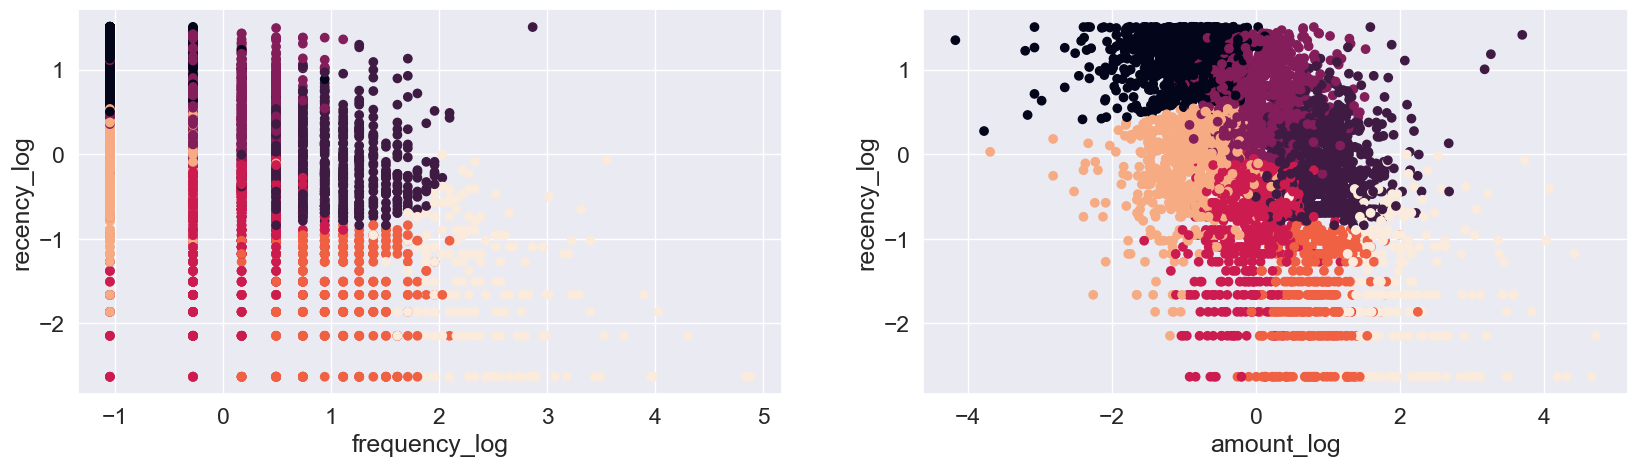

In [24]:
X_scaled = customer_history_df_scaled
feature_vector = ['recency_log','frequency_log','amount_log']
cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()

Khi sử dụng phương pháp Elbow bắt đầu với K bằng 3, chúng ta quan sát thấy với k = 7 thì độ giảm phương sai của cụm mạnh nhất với 10%. Từ đặc điểm này nên chúng ta sẽ bắt đầu đánh giá sâu hơn với k từ 3 đến 7. Chúng ta sẽ sử dụng phương pháp phân tích Silhouette.

**Bổ sung lý thuyết:**

Phân tích **Silhouette** trong phân cụm Kmeans

Phân tích Silhouette có thể được sử dụng để nghiên cứu khoảng cách giữa các cụm , như một chiến lược để định lượng chất lượng của việc phân nhóm hay phân cụm thông qua trực quan hoá để vẽ biểu đồ đo lường mức độ "chặt chẽ nhóm" của các mẫu trong các cụm. Biểu đồ Silhouette hiển thị thước đo mức độ gần của mỗi điểm trong một cụm với các điểm trong các cụm lân cận và do đó cung cấp cách để đánh giá các thông số như số lượng cụm một cách trực quan.

Cách phân tích này cũng có thể được áp dụng cho các thuật toán phân cụm khác ngoài k-means.

Hệ số Silhouette có phạm vi [-1, 1], và được tính bằng:
1. a(i) là khoảng cách trung bình giữa mẫu x(i) và tất cả các điểm khác trong cùng một cụm.
2. b(i) từ cụm gần nhất tiếp theo là khoảng cách trung bình giữa mẫu x(i) và tất cả các mẫu trong cụm gần nhất.
3. s(i) là sự khác biệt giữa a(i) và b(i) chia cho max(a(i), b(i)), như được hiển thị ở đây:

\begin{align} 
\text{s(i)} = \frac{b(i) - a(i)}{max\{a(i), b(i)\}} 
\end{align}

Một cách viết khác của công thức trên:

\begin{align}
        \text{s}(i) = \left\{
        \begin{array}{cl}
        1 - a(i)/b(i), & \text{if } a(i) < b(i) \\
        0, & \text{if } a(i) = b(i) \\
        b(i)/a(i) - 1, & \text{if } a(i) > b(i)
        \end{array}
        \right.
    \end{align}

Trong đó:
* Nếu gần +1, có nghĩa rằng mẫu ở xa các cụm lân cận.
* Giá trị cao chỉ ra rằng đối tượng được đối sánh tốt với cụm riêng của nó và đối sánh kém với các cụm lân cận.
* Nếu hầu hết các đối tượng có giá trị cao, thì cấu hình phân cụm là thích hợp.
* Nếu nhiều điểm có giá trị thấp hoặc âm, thì cấu hình phân cụm có thể có quá nhiều hoặc quá ít cụm.
* Giá trị 0 cho biết mẫu nằm trên hoặc rất gần ranh giới quyết định giữa hai cụm lân cận
* Giá trị âm chỉ ra rằng những mẫu đó có thể đã được chỉ định vào sai nhóm.

K được coi là không tốt khi các cụm có điểm Silhouette dưới trung bình hoặc có sự biến động lớn về kích thước của các ô Silhouette. K được coi là tốt khi tất cả các ô có độ dày tương tự hoặc không khác nhau nhiều hay nói cách khác tất cả các ô có kích thước tương tự.

Mặc dù chúng ta phải lưu ý rằng trong một số trường hợp và tình huống, đôi khi chúng ta có thể phải loại bỏ giải thích toán học do thuật toán đưa ra và xem xét mức độ phù hợp kinh doanh của kết quả thu được.

Hãy xem dữ liệu của chúng ta hoạt động như thế nào đối với từng giá trị K (3, 5 và 7) trong điểm Silhouette của mỗi cụm, cùng với trọng tâm của mỗi cụm được được đánh dấu trong các biểu đồ scatter, chúng ta sẽ phân cụm với 3 biến đầu vào là amount_log, recency_log, frequency_log nhưng sẽ hiển thị trên scatter theo từng cặp (amount_log, recency_log) và (amount_log, frequency_log)



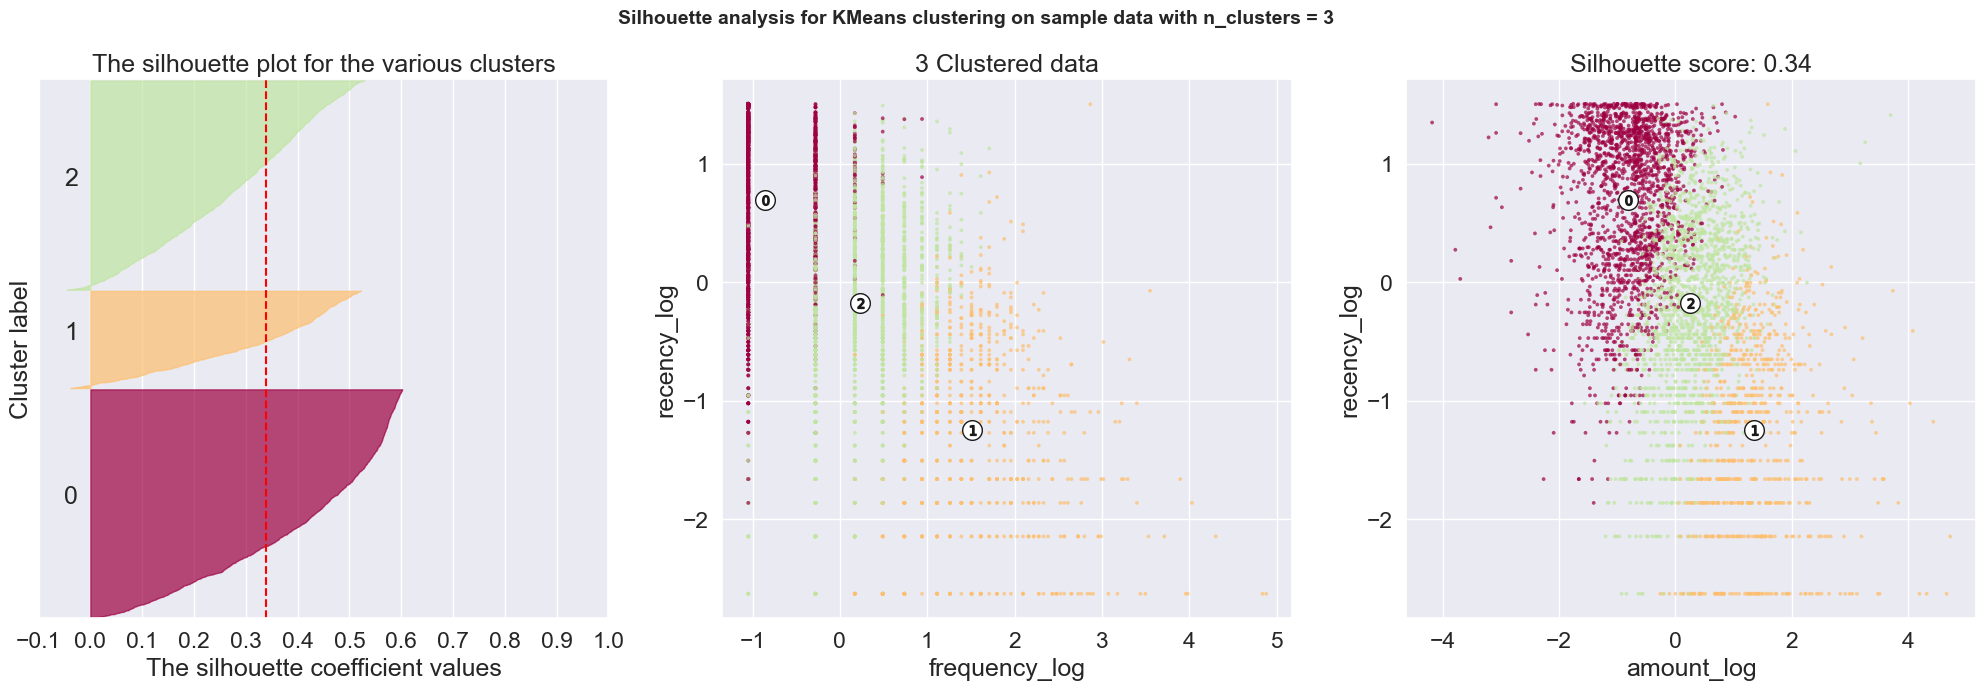

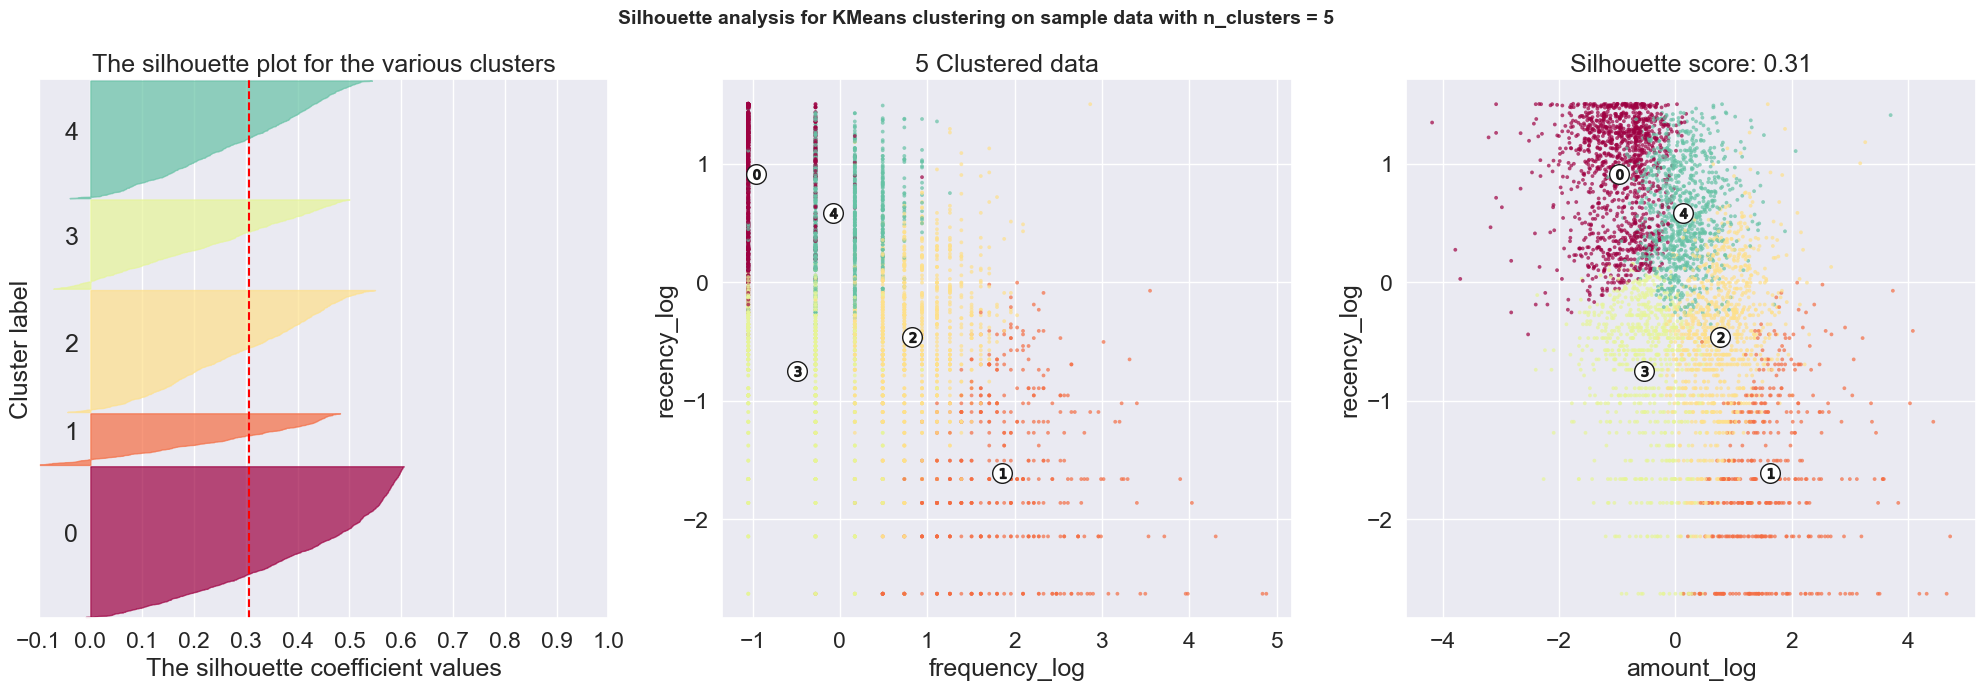

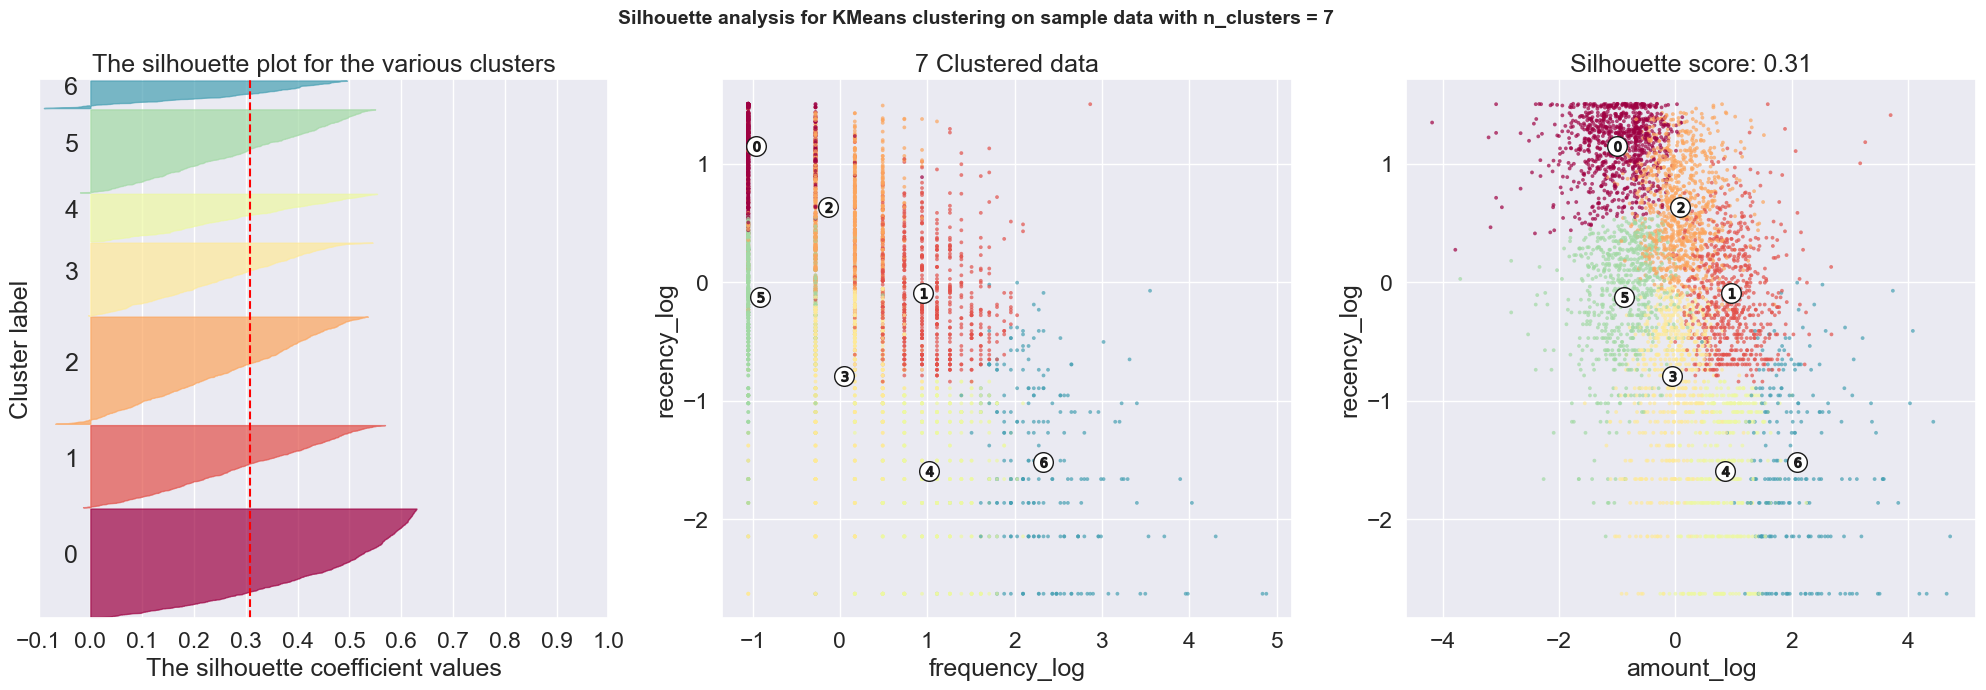

In [25]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1,2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

### Nhận xét:
Từ biểu đồ ta thấy:
 - Phân dữ liệu thành 3,5,7 cụm có điểm số silhouette trung bình gần như tương đương, các cụm điểm hình bóng cho mỗi cụm đều trên trung bình.
 - Phân thành 3 cụm tuy có điểm số silhouette trung bình cao nhất nhưng khi phân thành 3 cụm, số điểm trong mỗi cụm không đồng đều với nhau, cụm 0 và 2 dày hơn so với cụm 1. Phân thành cụm 7 thì đồng đều hơn
- Nhìn chung dù phân thành 3,5 hay 7 cụm thì vẫn tồn tại cá thể có điểm số silhouette dưới 0

##  Clusters Center

Hãy xem xét các giá trị trung tâm cụm được ánh xạ ngược lại từ các cụm tính trên thang đo log và Stardartcaler

In [26]:
# Hiển thị các tâm cụm
features = ['recency',  'frequency','amount']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Centers of each cluster:
      recency  frequency       amount
0  116.604917   1.190876   261.952265
1    7.236580  10.044493  3967.994380
2   33.819966   3.152227  1006.914317
--------------------------------------------------
for 5 clusters the silhouette score is 0.31
Centers of each cluster:
      recency  frequency       amount
0  160.737849   1.088263   213.438964
1    4.285608  13.677542  5708.668108
2   22.348243   5.414660  1930.204520
3   14.854813   1.649874   369.930740
4   99.752358   2.401419   863.647685
--------------------------------------------------
for 7 clusters the silhouette score is 0.31
Centers of each cluster:
      recency  frequency        amount
0  225.386840   1.083954    205.257565
1   38.058360   6.037971   2447.431580
2  107.621358   2.278104    810.639899
3   13.838593   2.689984    678.481625
4    4.419742   6.441601   2123.643873
5   36.207714   1.134226    240.091620
6    4.904358  20.795906  10213.306074

# 5. Clusters Insights

#### **Phân tích với từng K**





Với các ô và tâm ở các đơn vị chính xác, chúng ta hãy xem một số thông tin chi tiết theo từng nhóm cụm:

* Trường hợp có 3 cluster:
    - Cụm 0 (Low Value): là những khách hàng cũ, không phải khách hàng thường xuyên và giá trị đơn hàng thấp nhất.
    - Cụm 1 (High Value): là những khách hàng thường xuyên, mua hàng nhiều lần và có giá trị đơn hàng cao nhất.
    - Cụm 2 (Mid Value): là những khách hàng truy cập lần mua gần nhất tương đối lâu, mua hàng ít lần nhưng giá trị đơn hàng trung bình.
</br>
* Trường hợp có 5 cluster:
    - Cụm 0 (Lost): là những khách hàng có thời gian từ lần mua gần nhất khá lâu, tần suất mua hàng thấp và giá trị đơn hàng thấp nhất.
    - Cụm 1 (VIP): Là nhóm khách hàng mua hàng rất thường xuyên và có giá trị đơn hàng rất cao. Đây là nhóm có tần suất mua hàng cao nhất và giá trị đơn hàng cao nhất trong các cụm.
    - Cụm 2 (Potential): Là nhóm khách hàng mua hàng thường xuyên, giá trị đơn hàng trung bình cao và thời gian từ lần mua gần đây.
    - Cụm 3 (To sleep): là những khách hàng có thời gian mua mới gần đây, tần suất mua hàng vừa phải và giá trị đơn hàng thấp.
    - Cụm 4 (At Risk): là những khách hàng có thời gian từ lần mua gần nhất khá lâu, tần suất mua hàng vừa phải và giá trị đơn hàng trung bình.
</br>
* Trường hợp có 7 cluster:
    - Cụm 0 (Lost): là những khách hàng có thời gian từ lần mua gần nhất khá lâu, tần suất mua hàng thấp và giá trị đơn hàng thấp nhất.
    - Cụm 1 (Can't Lose Them): là nhóm khách hàng có thời gian từ lần mua gần nhất khá lâu, mua hàng nhiều lần và có giá trị đơn hàng cao.
    - Cụm 2 (Need be attention): là những khách hàng có thời gian từ lần mua gần nhất khá lâu, tần suất mua hàng vừa phải và giá trị đơn hàng trung bình.
    - Cụm 3 (At Risk): là những khách hàng có thời gian từ lần mua gần đây, tần suất mua hàng vừa phải và giá trị đơn hàng trung bình thấp.
    - Cụm 4 (VIP): Là nhóm khách hàng thường xuyên, mua hàng nhiều lần và có giá trị đơn hàng cao.
    - Cụm 5 (To sleep): là những khách hàng có thời gian từ lần mua gần nhất khá lâu, tần suất mua hàng thấp và giá trị đơn hàng thấp.
    - Cụm 6 (Champions): Là nhóm khách hàng mua hàng rất thường xuyên và có giá trị đơn hàng rất cao.






In [27]:
# Gán label cho khách hàng
for n_clusters in range(3,K_best+1,2):
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)
    customer_history_df[f'clusters_{n_clusters}'] = cluster_labels

customer_history_df.head()

,CustomerID,recency,frequency,amount,recency_log,frequency_log,amount_log,clusters_3,clusters_5,clusters_7
0,12346,326,1,77183.60,5.786897,0.000000,11.253942,2,4,1
1,12347,2,7,4310.00,0.693147,1.945910,8.368693,1,1,4
2,12348,75,4,1797.24,4.317488,1.386294,7.494007,2,4,1
3,12349,19,1,1757.55,2.944439,0.000000,7.471676,2,3,3
4,12350,310,1,334.40,5.736572,0.000000,5.812338,0,0,0


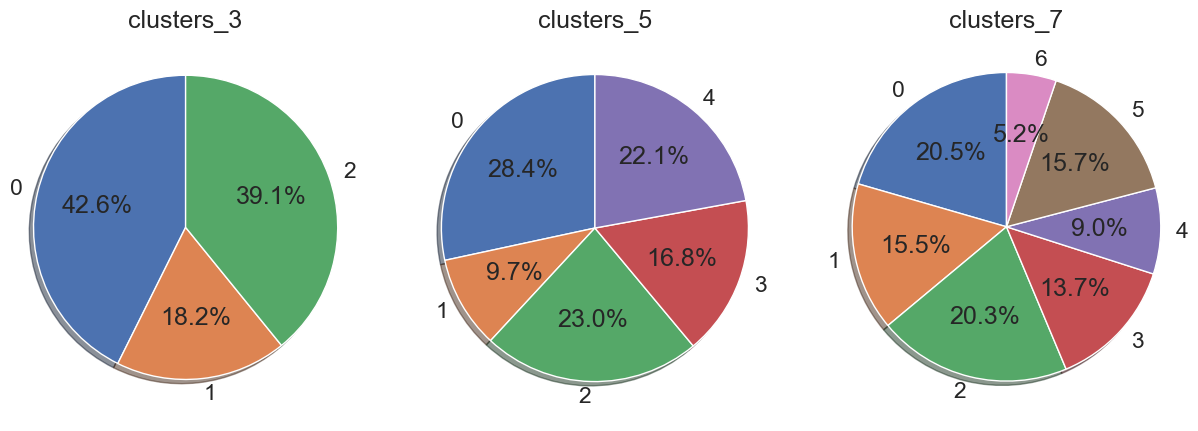

In [28]:
# Trực quan hoá tỷ lệ khách hàng mỗi cụm
cus_df = customer_history_df[['CustomerID','clusters_3','clusters_5','clusters_7']]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(cus_df.columns[1:]):
    cus_df_i = cus_df_i = cus_df.groupby(by=col).size()
    cus_df_i.plot(kind='pie',
                ax=axs[i],          
                autopct='%.1f%%',   
                startangle=90,      
                shadow=True,           
                )

    axs[i].set_title(col)
    axs[i].axis('equal')

plt.show()


### Nhận xét:
 - Nhóm khách hàng cũ, ít khi mua hàng và giá trị mua hàng thấp chiếm tỷ trọng khá cao như cụm 0 (clusters_3) là 42.6%, cụm 0, 3 (clusters_5) là 45.2%, cụm 0,5 (clusters_7) là 36.2%
 - Nhóm khách hàng truy cập cách đây tương đối lâu, mua hàng ít lần, giá trị hàng trung bình cũng có tỷ trọng tương đối cao thì như cụm 2 (clusters_3) là 39.1%, cụm 4 (clusters_5) là 22.1%, cụm 1,3,4 (clusters_7) là 38.4%
 - Nhóm khách hàng có giá trị mua hàng cao chiếm tỷ trọng thấp.

Biểu đồ hộp cho phép xem các giá trị xu hướng trung tâm trong mỗi biến. Chúng ta sẽ loại bỏ các giá trị ngoại lệ của mỗi nhóm, vì chúng sẽ cản trở việc quan sát tốt các xu hướng trung tâm của mỗi nhóm. Vì dữ liệu chỉ có các giá trị dương, nên chúng ta sẽ hạn chế dữ liệu sao cho chỉ sử dụng các điểm dữ liệu nhỏ hơn 0.95 phần trăm của cụm. Điều này sẽ cung cấp thông tin tốt về phần lớn người dùng trong mỗi cụm.

Chúng ta sẽ dùng biểu đồ hộp dưới đây để xem các ý đã nêu ra trong việc phân tích từng cụm ứng với mỗi K phía trên:

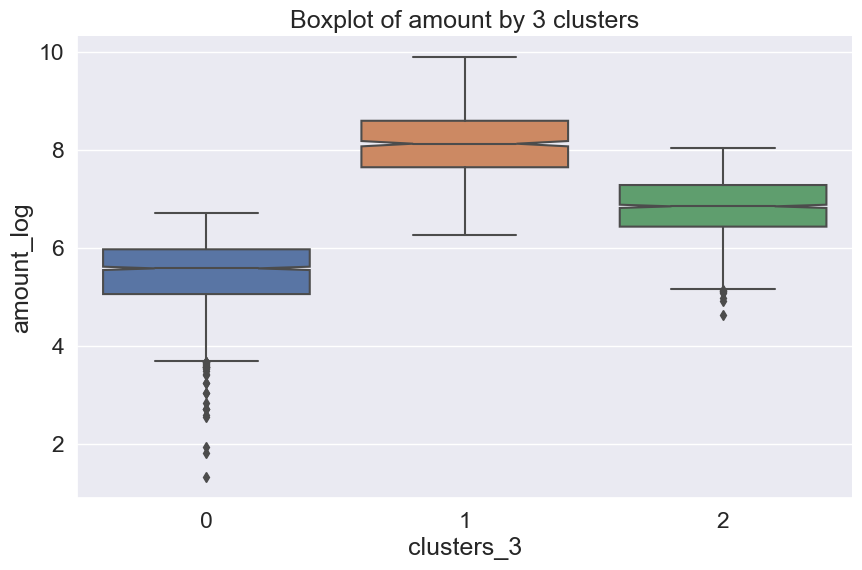

In [29]:
# lọc các cột cần thiết
cus_df_1 = customer_history_df[['CustomerID', 'clusters_3', 'clusters_5', 'clusters_7','amount_log']]
# Tính phân vị 0.95 cho từng cụm clusters_3
q95_cl3 = cus_df_1.groupby("clusters_3")["amount_log"].quantile(0.95)

# Hạn chế dữ liệu sao cho chỉ sử dụng các điểm dữ liệu nhỏ hơn phân vị 0.95 của cụm
df_cluster_cl3 = cus_df_1.set_index("clusters_3")
df_cluster_cl3 = df_cluster_cl3[df_cluster_cl3["amount_log"] <= q95_cl3[df_cluster_cl3.index]]
df_cluster_cl3 = df_cluster_cl3.reset_index()

# Sử dụng seaborn để vẽ biểu đồ boxplot
plt.figure(figsize=(10,6))
sns.boxplot(y="amount_log", x="clusters_3", data=df_cluster_cl3, notch=True)
sns.despine()
plt.title("Boxplot of amount by 3 clusters")
plt.show()

- Như đã thấy, nhóm 0 (Low Value) có số tiền chi tiêu thấp nhất. Vì thế cần tập trung vào chăm sóc 2 nhóm còn lại và khai thác khách hàng mới bù vào nhóm Low Value.

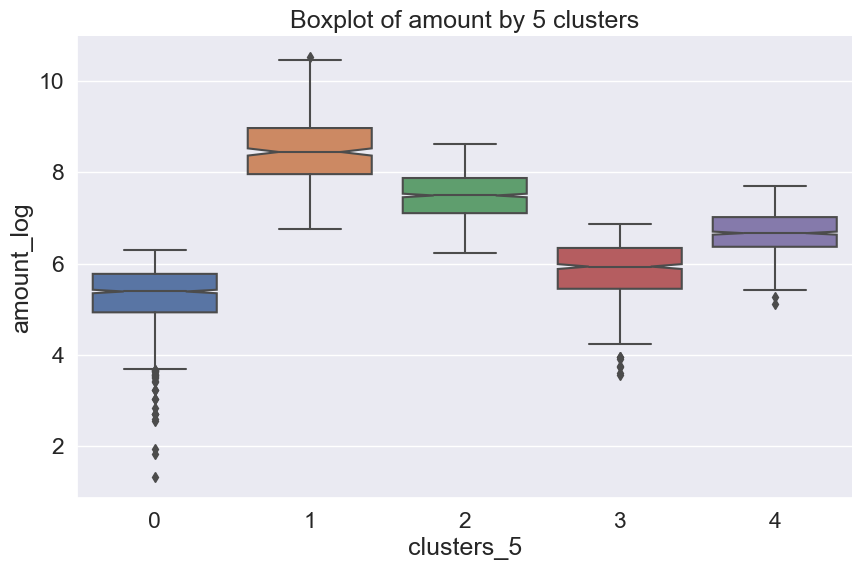

In [30]:
# Tính phân vị 0.95 cho từng cụm clusters_5
q95_cl5 = cus_df_1.groupby("clusters_5")["amount_log"].quantile(0.95)

# Hạn chế dữ liệu sao cho chỉ sử dụng các điểm dữ liệu nhỏ hơn phân vị 0.95 của cụm
df_cluster_cl5 = cus_df_1.set_index("clusters_5")
df_cluster_cl5 = df_cluster_cl5[df_cluster_cl5["amount_log"] <= q95_cl5[df_cluster_cl5.index]]
df_cluster_cl5 = df_cluster_cl5.reset_index()

# Sử dụng seaborn để vẽ biểu đồ boxplot
plt.figure(figsize=(10,6))
sns.boxplot(y="amount_log", x="clusters_5", data=df_cluster_cl5, notch=True)
sns.despine()
plt.title("Boxplot of amount by 5 clusters")
plt.show()

- Nên bỏ qua nhóm 0 (Lost), Cụm 3 (To sleep), tập trung chăm sóc khách hàng các nhóm còn lại 1 (VIP), 2 (Potential), 4 (At Risk)

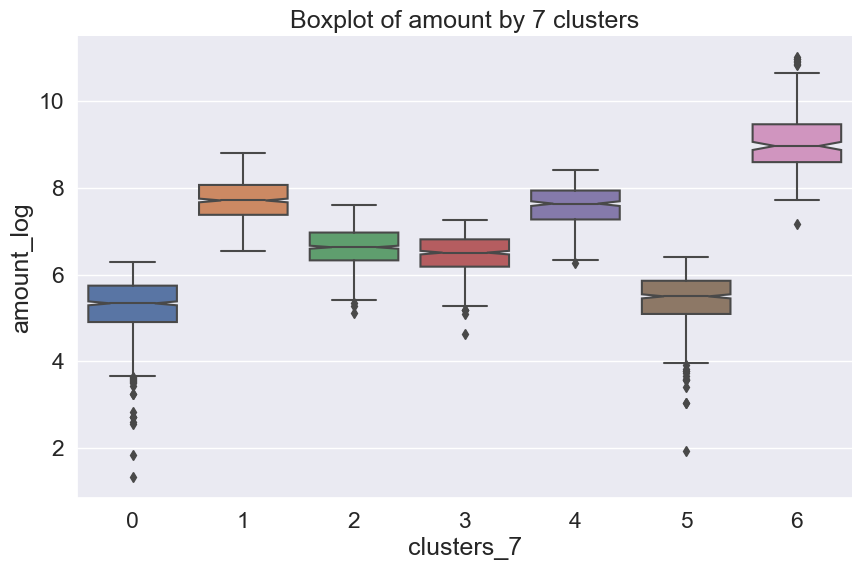

In [31]:
# Tính phân vị 0.95 cho từng cụm clusters_7
q95_cl7 = cus_df_1.groupby("clusters_7")["amount_log"].quantile(0.95)

# Hạn chế dữ liệu sao cho chỉ sử dụng các điểm dữ liệu nhỏ hơn phân vị 0.95 của cụm
df_cluster_cl7 = cus_df_1.set_index("clusters_7")
df_cluster_cl7 = df_cluster_cl7[df_cluster_cl7["amount_log"] <= q95_cl7[df_cluster_cl7.index]]
df_cluster_cl7 = df_cluster_cl7.reset_index()

# Sử dụng seaborn để vẽ biểu đồ boxplot
plt.figure(figsize=(10,6))
sns.boxplot(y="amount_log", x="clusters_7", data=df_cluster_cl7, notch=True)
sns.despine()
plt.title("Boxplot of amount by 7 clusters")
plt.show()

- Nên bỏ qua nhóm 0 (Lost),  5 (To sleep) tập trung các nhóm  1 (Can't Lose Them),  2 (Need be attention), 3 (At Risk) , 4 (VIP),  6 (Champions)


### Nhận xét:
- Khi chia nhiều cụm chi tiết sẽ có cái nhìn rõ ràng hơn về dặc điểm của mỗi nhóm khách hàng
- Khi đã có chọn được phân khúc khách hàng, tuỳ vào chiến lược của doanh nghiệp sẽ có những chương trình marketing phù hợp tránh lãng phí tài nguyên.
- Nếu cần có thể phân tích sâu hơn về nhóm khách hàng mà doanh nghiệp muốn hướng đến. Ví dụ: Phân tích nhóm khách hàng VIP và Champions là gồm những ai? (về nghề nghiệp, độ tuổi, thu nhập, ...)